# sEMG CNN training 
Based implementation on https://github.com/healthDataScience/deep-learning-HAR and modified to fit our dataset.

In [1]:
import numpy as np
import os
from utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

Read in data and split into train/test portions:

In [2]:
path = os.path.abspath(os.getcwd())
X_train, labels_train, list_ch_train, X_test, labels_test, list_ch_test = read_data(
    data_path='%s%ssEMG%sDatabase 2%s' % (path, os.sep, os.sep, os.sep),
    shuffle=True,
    sub_split=True
)

assert list_ch_train == list_ch_test, 'Mismatch in channels!'

In [3]:
X_train, X_test = standardize(X_train, X_test)

Train/validation split using sklearn utility. Manually specify random state seed to make testing more deterministic.

In [4]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(
    X_train,
    labels_train, 
    stratify=labels_train,
    random_state=123
)

One-hot encoding:

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

## Initialize Tensorflow + Hyperparameters

In [6]:
import tensorflow as tf

# The following were determined through iterative trial and error:
batch_size = 100
seq_len = 2496
learning_rate = 0.00001
epochs = 2500

n_classes = 6
n_channels = 2

## Construct Graph
Placeholders:

In [7]:
graph = tf.Graph()

with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name='inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name='labels')
    keep_prob_ = tf.placeholder(tf.float32, name='keep')
    learning_rate_ = tf.placeholder(tf.float32, name='learning_rate')

## Build Convolutional Layers

In [8]:
with graph.as_default():
    
    # (batch, 2496, 2) --> (batch, 1248, 4)
    conv1 = tf.layers.conv1d(
        inputs=inputs_,
        filters=4,
        kernel_size=2,
        strides=1, 
        padding='same',
        activation=tf.nn.relu
    )
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 1248, 4) --> (batch, 624, 8)
    conv2 = tf.layers.conv1d(
        inputs=max_pool_1,
        filters=8,
        kernel_size=2,
        strides=1,          
        padding='same',
        activation=tf.nn.relu
    )
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 624, 8) --> (batch, 312, 16)
    conv3 = tf.layers.conv1d(
        inputs=max_pool_2,
        filters=16,
        kernel_size=2,
        strides=1,
        padding='same',
        activation=tf.nn.relu
    )
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 312, 16) --> (batch, 156, 32)
    conv4 = tf.layers.conv1d(
        inputs=max_pool_3,
        filters=32,
        kernel_size=2,
        strides=1,
        padding='same',
        activation = tf.nn.relu
    )
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
    
    # (batch, 156, 32) --> (batch, 78, 64)
    conv5 = tf.layers.conv1d(
        inputs=max_pool_4,
        filters=64,
        kernel_size=2,
        strides=1,
        padding='same',
        activation = tf.nn.relu
    )
    max_pool_5 = tf.layers.max_pooling1d(inputs=conv5, pool_size=2, strides=2, padding='same')
    
    # (batch, 78, 64) --> (batch, 39, 128)
    conv6 = tf.layers.conv1d(
        inputs=max_pool_5,
        filters=128,
        kernel_size=2,
        strides=1,
        padding='same',
        activation = tf.nn.relu
    )
    max_pool_6 = tf.layers.max_pooling1d(inputs=conv6, pool_size=2, strides=2, padding='same')
    

Pass to classifier:

In [9]:
with graph.as_default():
    # Reshape, add dropout (dimensions match final convultional layer)
    flat = tf.reshape(max_pool_6, (-1, 128 * 39))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

## Train the network

In [10]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [11]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_: x, labels_: y, keep_prob_: 0.5, learning_rate_: learning_rate}
            
            # Loss
            loss, _, acc = sess.run([cost, optimizer, accuracy], feed_dict=feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iterations
            if (iteration % 5 == 0):
                print(
                    'Epoch: {}/{}'.format(e, epochs),
                    'Iteration: {:d}'.format(iteration),
                    'Train loss: {:6f}'.format(loss),
                    'Train acc: {:.6f}'.format(acc)
                )
            
            # Compute validation loss at every 10 iterations
            if (iteration % 10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    
                    # Feed
                    feed = {inputs_: x_v, labels_: y_v, keep_prob_: 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict=feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Display info
                print(
                    'Epoch: {}/{}'.format(e, epochs),
                    'Iteration: {:d}'.format(iteration),
                    'Validation loss: {:6f}'.format(np.mean(val_loss_)),
                    'Validation acc: {:.6f}'.format(np.mean(val_acc_))
                )
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            iteration += 1
    
    saver.save(sess,'checkpoints-cnn/semg.ckpt')

Epoch: 0/2500 Iteration: 5 Train loss: 1.801583 Train acc: 0.160000
Epoch: 1/2500 Iteration: 10 Train loss: 1.787749 Train acc: 0.210000
Epoch: 1/2500 Iteration: 10 Validation loss: 1.763089 Validation acc: 0.175000
Epoch: 2/2500 Iteration: 15 Train loss: 1.813622 Train acc: 0.120000
Epoch: 3/2500 Iteration: 20 Train loss: 1.790460 Train acc: 0.200000
Epoch: 3/2500 Iteration: 20 Validation loss: 1.753234 Validation acc: 0.205000
Epoch: 4/2500 Iteration: 25 Train loss: 1.788561 Train acc: 0.170000
Epoch: 4/2500 Iteration: 30 Train loss: 1.745197 Train acc: 0.170000
Epoch: 4/2500 Iteration: 30 Validation loss: 1.744483 Validation acc: 0.215000
Epoch: 5/2500 Iteration: 35 Train loss: 1.770858 Train acc: 0.200000
Epoch: 6/2500 Iteration: 40 Train loss: 1.701877 Train acc: 0.250000
Epoch: 6/2500 Iteration: 40 Validation loss: 1.736814 Validation acc: 0.235000
Epoch: 7/2500 Iteration: 45 Train loss: 1.762761 Train acc: 0.170000
Epoch: 8/2500 Iteration: 50 Train loss: 1.794354 Train acc: 0.18

Epoch: 64/2500 Iteration: 390 Train loss: 1.526053 Train acc: 0.320000
Epoch: 64/2500 Iteration: 390 Validation loss: 1.614483 Validation acc: 0.250000
Epoch: 65/2500 Iteration: 395 Train loss: 1.557733 Train acc: 0.300000
Epoch: 66/2500 Iteration: 400 Train loss: 1.592343 Train acc: 0.260000
Epoch: 66/2500 Iteration: 400 Validation loss: 1.611542 Validation acc: 0.260000
Epoch: 67/2500 Iteration: 405 Train loss: 1.652067 Train acc: 0.220000
Epoch: 68/2500 Iteration: 410 Train loss: 1.632777 Train acc: 0.230000
Epoch: 68/2500 Iteration: 410 Validation loss: 1.608639 Validation acc: 0.260000
Epoch: 69/2500 Iteration: 415 Train loss: 1.617646 Train acc: 0.360000
Epoch: 69/2500 Iteration: 420 Train loss: 1.542698 Train acc: 0.300000
Epoch: 69/2500 Iteration: 420 Validation loss: 1.605747 Validation acc: 0.265000
Epoch: 70/2500 Iteration: 425 Train loss: 1.598073 Train acc: 0.220000
Epoch: 71/2500 Iteration: 430 Train loss: 1.576476 Train acc: 0.330000
Epoch: 71/2500 Iteration: 430 Validat

Epoch: 126/2500 Iteration: 760 Train loss: 1.394698 Train acc: 0.410000
Epoch: 126/2500 Iteration: 760 Validation loss: 1.501418 Validation acc: 0.330000
Epoch: 127/2500 Iteration: 765 Train loss: 1.562229 Train acc: 0.350000
Epoch: 128/2500 Iteration: 770 Train loss: 1.557739 Train acc: 0.360000
Epoch: 128/2500 Iteration: 770 Validation loss: 1.498196 Validation acc: 0.330000
Epoch: 129/2500 Iteration: 775 Train loss: 1.542690 Train acc: 0.340000
Epoch: 129/2500 Iteration: 780 Train loss: 1.395061 Train acc: 0.430000
Epoch: 129/2500 Iteration: 780 Validation loss: 1.494987 Validation acc: 0.330000
Epoch: 130/2500 Iteration: 785 Train loss: 1.489454 Train acc: 0.350000
Epoch: 131/2500 Iteration: 790 Train loss: 1.412491 Train acc: 0.420000
Epoch: 131/2500 Iteration: 790 Validation loss: 1.491763 Validation acc: 0.330000
Epoch: 132/2500 Iteration: 795 Train loss: 1.543002 Train acc: 0.300000
Epoch: 133/2500 Iteration: 800 Train loss: 1.506950 Train acc: 0.300000
Epoch: 133/2500 Iteratio

Epoch: 189/2500 Iteration: 1140 Train loss: 1.294491 Train acc: 0.500000
Epoch: 189/2500 Iteration: 1140 Validation loss: 1.376505 Validation acc: 0.440000
Epoch: 190/2500 Iteration: 1145 Train loss: 1.410151 Train acc: 0.380000
Epoch: 191/2500 Iteration: 1150 Train loss: 1.317179 Train acc: 0.490000
Epoch: 191/2500 Iteration: 1150 Validation loss: 1.373101 Validation acc: 0.440000
Epoch: 192/2500 Iteration: 1155 Train loss: 1.395902 Train acc: 0.440000
Epoch: 193/2500 Iteration: 1160 Train loss: 1.390228 Train acc: 0.410000
Epoch: 193/2500 Iteration: 1160 Validation loss: 1.369703 Validation acc: 0.440000
Epoch: 194/2500 Iteration: 1165 Train loss: 1.385083 Train acc: 0.460000
Epoch: 194/2500 Iteration: 1170 Train loss: 1.263027 Train acc: 0.550000
Epoch: 194/2500 Iteration: 1170 Validation loss: 1.366204 Validation acc: 0.455000
Epoch: 195/2500 Iteration: 1175 Train loss: 1.329911 Train acc: 0.480000
Epoch: 196/2500 Iteration: 1180 Train loss: 1.247359 Train acc: 0.540000
Epoch: 196/

Epoch: 252/2500 Iteration: 1515 Train loss: 1.269490 Train acc: 0.560000
Epoch: 253/2500 Iteration: 1520 Train loss: 1.319009 Train acc: 0.450000
Epoch: 253/2500 Iteration: 1520 Validation loss: 1.245132 Validation acc: 0.545000
Epoch: 254/2500 Iteration: 1525 Train loss: 1.302714 Train acc: 0.530000
Epoch: 254/2500 Iteration: 1530 Train loss: 1.119011 Train acc: 0.610000
Epoch: 254/2500 Iteration: 1530 Validation loss: 1.241982 Validation acc: 0.550000
Epoch: 255/2500 Iteration: 1535 Train loss: 1.240035 Train acc: 0.530000
Epoch: 256/2500 Iteration: 1540 Train loss: 1.210675 Train acc: 0.530000
Epoch: 256/2500 Iteration: 1540 Validation loss: 1.239134 Validation acc: 0.550000
Epoch: 257/2500 Iteration: 1545 Train loss: 1.206774 Train acc: 0.560000
Epoch: 258/2500 Iteration: 1550 Train loss: 1.267558 Train acc: 0.530000
Epoch: 258/2500 Iteration: 1550 Validation loss: 1.236006 Validation acc: 0.545000
Epoch: 259/2500 Iteration: 1555 Train loss: 1.307308 Train acc: 0.530000
Epoch: 259/

Epoch: 312/2500 Iteration: 1875 Train loss: 1.036978 Train acc: 0.640000
Epoch: 313/2500 Iteration: 1880 Train loss: 1.152738 Train acc: 0.560000
Epoch: 313/2500 Iteration: 1880 Validation loss: 1.131364 Validation acc: 0.600000
Epoch: 314/2500 Iteration: 1885 Train loss: 1.165392 Train acc: 0.630000
Epoch: 314/2500 Iteration: 1890 Train loss: 1.054188 Train acc: 0.580000
Epoch: 314/2500 Iteration: 1890 Validation loss: 1.128463 Validation acc: 0.600000
Epoch: 315/2500 Iteration: 1895 Train loss: 1.082041 Train acc: 0.640000
Epoch: 316/2500 Iteration: 1900 Train loss: 0.982097 Train acc: 0.630000
Epoch: 316/2500 Iteration: 1900 Validation loss: 1.125329 Validation acc: 0.600000
Epoch: 317/2500 Iteration: 1905 Train loss: 1.103790 Train acc: 0.620000
Epoch: 318/2500 Iteration: 1910 Train loss: 1.142316 Train acc: 0.600000
Epoch: 318/2500 Iteration: 1910 Validation loss: 1.122202 Validation acc: 0.615000
Epoch: 319/2500 Iteration: 1915 Train loss: 1.173098 Train acc: 0.600000
Epoch: 319/

Epoch: 372/2500 Iteration: 2235 Train loss: 0.943808 Train acc: 0.660000
Epoch: 373/2500 Iteration: 2240 Train loss: 1.062664 Train acc: 0.680000
Epoch: 373/2500 Iteration: 2240 Validation loss: 1.032001 Validation acc: 0.630000
Epoch: 374/2500 Iteration: 2245 Train loss: 1.067448 Train acc: 0.600000
Epoch: 374/2500 Iteration: 2250 Train loss: 0.893312 Train acc: 0.660000
Epoch: 374/2500 Iteration: 2250 Validation loss: 1.029124 Validation acc: 0.630000
Epoch: 375/2500 Iteration: 2255 Train loss: 0.998124 Train acc: 0.690000
Epoch: 376/2500 Iteration: 2260 Train loss: 0.915548 Train acc: 0.680000
Epoch: 376/2500 Iteration: 2260 Validation loss: 1.026281 Validation acc: 0.630000
Epoch: 377/2500 Iteration: 2265 Train loss: 0.918067 Train acc: 0.730000
Epoch: 378/2500 Iteration: 2270 Train loss: 1.060883 Train acc: 0.620000
Epoch: 378/2500 Iteration: 2270 Validation loss: 1.023361 Validation acc: 0.630000
Epoch: 379/2500 Iteration: 2275 Train loss: 1.043333 Train acc: 0.640000
Epoch: 379/

Epoch: 432/2500 Iteration: 2595 Train loss: 0.862233 Train acc: 0.710000
Epoch: 433/2500 Iteration: 2600 Train loss: 0.931100 Train acc: 0.660000
Epoch: 433/2500 Iteration: 2600 Validation loss: 0.944962 Validation acc: 0.655000
Epoch: 434/2500 Iteration: 2605 Train loss: 0.979858 Train acc: 0.680000
Epoch: 434/2500 Iteration: 2610 Train loss: 0.827115 Train acc: 0.700000
Epoch: 434/2500 Iteration: 2610 Validation loss: 0.942732 Validation acc: 0.660000
Epoch: 435/2500 Iteration: 2615 Train loss: 0.915626 Train acc: 0.610000
Epoch: 436/2500 Iteration: 2620 Train loss: 0.805112 Train acc: 0.690000
Epoch: 436/2500 Iteration: 2620 Validation loss: 0.940518 Validation acc: 0.665000
Epoch: 437/2500 Iteration: 2625 Train loss: 0.808430 Train acc: 0.760000
Epoch: 438/2500 Iteration: 2630 Train loss: 0.919645 Train acc: 0.740000
Epoch: 438/2500 Iteration: 2630 Validation loss: 0.938042 Validation acc: 0.665000
Epoch: 439/2500 Iteration: 2635 Train loss: 0.957200 Train acc: 0.670000
Epoch: 439/

Epoch: 494/2500 Iteration: 2970 Train loss: 0.775881 Train acc: 0.700000
Epoch: 494/2500 Iteration: 2970 Validation loss: 0.868227 Validation acc: 0.700000
Epoch: 495/2500 Iteration: 2975 Train loss: 0.827043 Train acc: 0.720000
Epoch: 496/2500 Iteration: 2980 Train loss: 0.738169 Train acc: 0.710000
Epoch: 496/2500 Iteration: 2980 Validation loss: 0.866303 Validation acc: 0.700000
Epoch: 497/2500 Iteration: 2985 Train loss: 0.707354 Train acc: 0.780000
Epoch: 498/2500 Iteration: 2990 Train loss: 0.871071 Train acc: 0.710000
Epoch: 498/2500 Iteration: 2990 Validation loss: 0.864660 Validation acc: 0.700000
Epoch: 499/2500 Iteration: 2995 Train loss: 0.863377 Train acc: 0.700000
Epoch: 499/2500 Iteration: 3000 Train loss: 0.783632 Train acc: 0.710000
Epoch: 499/2500 Iteration: 3000 Validation loss: 0.862941 Validation acc: 0.700000
Epoch: 500/2500 Iteration: 3005 Train loss: 0.795575 Train acc: 0.750000
Epoch: 501/2500 Iteration: 3010 Train loss: 0.711880 Train acc: 0.730000
Epoch: 501/

Epoch: 554/2500 Iteration: 3330 Train loss: 0.702673 Train acc: 0.750000
Epoch: 554/2500 Iteration: 3330 Validation loss: 0.809407 Validation acc: 0.730000
Epoch: 555/2500 Iteration: 3335 Train loss: 0.709267 Train acc: 0.750000
Epoch: 556/2500 Iteration: 3340 Train loss: 0.634790 Train acc: 0.790000
Epoch: 556/2500 Iteration: 3340 Validation loss: 0.807225 Validation acc: 0.725000
Epoch: 557/2500 Iteration: 3345 Train loss: 0.633941 Train acc: 0.780000
Epoch: 558/2500 Iteration: 3350 Train loss: 0.781948 Train acc: 0.700000
Epoch: 558/2500 Iteration: 3350 Validation loss: 0.805659 Validation acc: 0.725000
Epoch: 559/2500 Iteration: 3355 Train loss: 0.779006 Train acc: 0.800000
Epoch: 559/2500 Iteration: 3360 Train loss: 0.692261 Train acc: 0.770000
Epoch: 559/2500 Iteration: 3360 Validation loss: 0.804343 Validation acc: 0.730000
Epoch: 560/2500 Iteration: 3365 Train loss: 0.703839 Train acc: 0.750000
Epoch: 561/2500 Iteration: 3370 Train loss: 0.675918 Train acc: 0.760000
Epoch: 561/

Epoch: 614/2500 Iteration: 3690 Train loss: 0.584439 Train acc: 0.820000
Epoch: 614/2500 Iteration: 3690 Validation loss: 0.757525 Validation acc: 0.745000
Epoch: 615/2500 Iteration: 3695 Train loss: 0.646913 Train acc: 0.810000
Epoch: 616/2500 Iteration: 3700 Train loss: 0.637041 Train acc: 0.730000
Epoch: 616/2500 Iteration: 3700 Validation loss: 0.755893 Validation acc: 0.745000
Epoch: 617/2500 Iteration: 3705 Train loss: 0.560992 Train acc: 0.840000
Epoch: 618/2500 Iteration: 3710 Train loss: 0.808693 Train acc: 0.690000
Epoch: 618/2500 Iteration: 3710 Validation loss: 0.754483 Validation acc: 0.745000
Epoch: 619/2500 Iteration: 3715 Train loss: 0.769501 Train acc: 0.740000
Epoch: 619/2500 Iteration: 3720 Train loss: 0.593898 Train acc: 0.780000
Epoch: 619/2500 Iteration: 3720 Validation loss: 0.753386 Validation acc: 0.745000
Epoch: 620/2500 Iteration: 3725 Train loss: 0.659919 Train acc: 0.770000
Epoch: 621/2500 Iteration: 3730 Train loss: 0.647952 Train acc: 0.710000
Epoch: 621/

Epoch: 677/2500 Iteration: 4065 Train loss: 0.536168 Train acc: 0.810000
Epoch: 678/2500 Iteration: 4070 Train loss: 0.713314 Train acc: 0.730000
Epoch: 678/2500 Iteration: 4070 Validation loss: 0.710710 Validation acc: 0.760000
Epoch: 679/2500 Iteration: 4075 Train loss: 0.634166 Train acc: 0.810000
Epoch: 679/2500 Iteration: 4080 Train loss: 0.568998 Train acc: 0.810000
Epoch: 679/2500 Iteration: 4080 Validation loss: 0.709564 Validation acc: 0.760000
Epoch: 680/2500 Iteration: 4085 Train loss: 0.612937 Train acc: 0.770000
Epoch: 681/2500 Iteration: 4090 Train loss: 0.522538 Train acc: 0.830000
Epoch: 681/2500 Iteration: 4090 Validation loss: 0.708795 Validation acc: 0.760000
Epoch: 682/2500 Iteration: 4095 Train loss: 0.558811 Train acc: 0.780000
Epoch: 683/2500 Iteration: 4100 Train loss: 0.658168 Train acc: 0.740000
Epoch: 683/2500 Iteration: 4100 Validation loss: 0.707658 Validation acc: 0.760000
Epoch: 684/2500 Iteration: 4105 Train loss: 0.731376 Train acc: 0.730000
Epoch: 684/

Epoch: 737/2500 Iteration: 4425 Train loss: 0.515115 Train acc: 0.830000
Epoch: 738/2500 Iteration: 4430 Train loss: 0.634844 Train acc: 0.790000
Epoch: 738/2500 Iteration: 4430 Validation loss: 0.672878 Validation acc: 0.770000
Epoch: 739/2500 Iteration: 4435 Train loss: 0.665472 Train acc: 0.770000
Epoch: 739/2500 Iteration: 4440 Train loss: 0.486107 Train acc: 0.870000
Epoch: 739/2500 Iteration: 4440 Validation loss: 0.671760 Validation acc: 0.770000
Epoch: 740/2500 Iteration: 4445 Train loss: 0.633862 Train acc: 0.800000
Epoch: 741/2500 Iteration: 4450 Train loss: 0.533624 Train acc: 0.750000
Epoch: 741/2500 Iteration: 4450 Validation loss: 0.670977 Validation acc: 0.770000
Epoch: 742/2500 Iteration: 4455 Train loss: 0.496120 Train acc: 0.840000
Epoch: 743/2500 Iteration: 4460 Train loss: 0.604370 Train acc: 0.790000
Epoch: 743/2500 Iteration: 4460 Validation loss: 0.669706 Validation acc: 0.770000
Epoch: 744/2500 Iteration: 4465 Train loss: 0.618195 Train acc: 0.780000
Epoch: 744/

Epoch: 799/2500 Iteration: 4800 Train loss: 0.449006 Train acc: 0.900000
Epoch: 799/2500 Iteration: 4800 Validation loss: 0.637225 Validation acc: 0.770000
Epoch: 800/2500 Iteration: 4805 Train loss: 0.529843 Train acc: 0.860000
Epoch: 801/2500 Iteration: 4810 Train loss: 0.474418 Train acc: 0.820000
Epoch: 801/2500 Iteration: 4810 Validation loss: 0.636495 Validation acc: 0.775000
Epoch: 802/2500 Iteration: 4815 Train loss: 0.491395 Train acc: 0.850000
Epoch: 803/2500 Iteration: 4820 Train loss: 0.711627 Train acc: 0.770000
Epoch: 803/2500 Iteration: 4820 Validation loss: 0.636607 Validation acc: 0.785000
Epoch: 804/2500 Iteration: 4825 Train loss: 0.606122 Train acc: 0.830000
Epoch: 804/2500 Iteration: 4830 Train loss: 0.492419 Train acc: 0.840000
Epoch: 804/2500 Iteration: 4830 Validation loss: 0.635501 Validation acc: 0.785000
Epoch: 805/2500 Iteration: 4835 Train loss: 0.520731 Train acc: 0.790000
Epoch: 806/2500 Iteration: 4840 Train loss: 0.479006 Train acc: 0.800000
Epoch: 806/

Epoch: 861/2500 Iteration: 5170 Train loss: 0.464901 Train acc: 0.820000
Epoch: 861/2500 Iteration: 5170 Validation loss: 0.608615 Validation acc: 0.785000
Epoch: 862/2500 Iteration: 5175 Train loss: 0.440259 Train acc: 0.860000
Epoch: 863/2500 Iteration: 5180 Train loss: 0.533325 Train acc: 0.820000
Epoch: 863/2500 Iteration: 5180 Validation loss: 0.607402 Validation acc: 0.790000
Epoch: 864/2500 Iteration: 5185 Train loss: 0.598929 Train acc: 0.780000
Epoch: 864/2500 Iteration: 5190 Train loss: 0.466102 Train acc: 0.870000
Epoch: 864/2500 Iteration: 5190 Validation loss: 0.606287 Validation acc: 0.785000
Epoch: 865/2500 Iteration: 5195 Train loss: 0.462543 Train acc: 0.860000
Epoch: 866/2500 Iteration: 5200 Train loss: 0.494439 Train acc: 0.820000
Epoch: 866/2500 Iteration: 5200 Validation loss: 0.605523 Validation acc: 0.780000
Epoch: 867/2500 Iteration: 5205 Train loss: 0.391941 Train acc: 0.900000
Epoch: 868/2500 Iteration: 5210 Train loss: 0.546879 Train acc: 0.830000
Epoch: 868/

Epoch: 923/2500 Iteration: 5540 Train loss: 0.508541 Train acc: 0.800000
Epoch: 923/2500 Iteration: 5540 Validation loss: 0.582826 Validation acc: 0.785000
Epoch: 924/2500 Iteration: 5545 Train loss: 0.488118 Train acc: 0.850000
Epoch: 924/2500 Iteration: 5550 Train loss: 0.406160 Train acc: 0.870000
Epoch: 924/2500 Iteration: 5550 Validation loss: 0.582515 Validation acc: 0.785000
Epoch: 925/2500 Iteration: 5555 Train loss: 0.471086 Train acc: 0.830000
Epoch: 926/2500 Iteration: 5560 Train loss: 0.425323 Train acc: 0.830000
Epoch: 926/2500 Iteration: 5560 Validation loss: 0.582206 Validation acc: 0.785000
Epoch: 927/2500 Iteration: 5565 Train loss: 0.410011 Train acc: 0.870000
Epoch: 928/2500 Iteration: 5570 Train loss: 0.513144 Train acc: 0.800000
Epoch: 928/2500 Iteration: 5570 Validation loss: 0.581421 Validation acc: 0.785000
Epoch: 929/2500 Iteration: 5575 Train loss: 0.498918 Train acc: 0.840000
Epoch: 929/2500 Iteration: 5580 Train loss: 0.409582 Train acc: 0.850000
Epoch: 929/

Epoch: 983/2500 Iteration: 5900 Train loss: 0.464508 Train acc: 0.840000
Epoch: 983/2500 Iteration: 5900 Validation loss: 0.562411 Validation acc: 0.790000
Epoch: 984/2500 Iteration: 5905 Train loss: 0.513089 Train acc: 0.820000
Epoch: 984/2500 Iteration: 5910 Train loss: 0.391180 Train acc: 0.880000
Epoch: 984/2500 Iteration: 5910 Validation loss: 0.561320 Validation acc: 0.785000
Epoch: 985/2500 Iteration: 5915 Train loss: 0.441084 Train acc: 0.860000
Epoch: 986/2500 Iteration: 5920 Train loss: 0.425000 Train acc: 0.850000
Epoch: 986/2500 Iteration: 5920 Validation loss: 0.560694 Validation acc: 0.790000
Epoch: 987/2500 Iteration: 5925 Train loss: 0.375729 Train acc: 0.860000
Epoch: 988/2500 Iteration: 5930 Train loss: 0.494903 Train acc: 0.770000
Epoch: 988/2500 Iteration: 5930 Validation loss: 0.560111 Validation acc: 0.790000
Epoch: 989/2500 Iteration: 5935 Train loss: 0.486142 Train acc: 0.830000
Epoch: 989/2500 Iteration: 5940 Train loss: 0.413962 Train acc: 0.880000
Epoch: 989/

Epoch: 1043/2500 Iteration: 6260 Train loss: 0.445129 Train acc: 0.830000
Epoch: 1043/2500 Iteration: 6260 Validation loss: 0.544930 Validation acc: 0.790000
Epoch: 1044/2500 Iteration: 6265 Train loss: 0.444270 Train acc: 0.830000
Epoch: 1044/2500 Iteration: 6270 Train loss: 0.357959 Train acc: 0.890000
Epoch: 1044/2500 Iteration: 6270 Validation loss: 0.544006 Validation acc: 0.790000
Epoch: 1045/2500 Iteration: 6275 Train loss: 0.409428 Train acc: 0.870000
Epoch: 1046/2500 Iteration: 6280 Train loss: 0.414289 Train acc: 0.820000
Epoch: 1046/2500 Iteration: 6280 Validation loss: 0.543734 Validation acc: 0.790000
Epoch: 1047/2500 Iteration: 6285 Train loss: 0.373119 Train acc: 0.880000
Epoch: 1048/2500 Iteration: 6290 Train loss: 0.512996 Train acc: 0.840000
Epoch: 1048/2500 Iteration: 6290 Validation loss: 0.543813 Validation acc: 0.790000
Epoch: 1049/2500 Iteration: 6295 Train loss: 0.470922 Train acc: 0.840000
Epoch: 1049/2500 Iteration: 6300 Train loss: 0.378713 Train acc: 0.87000

Epoch: 1104/2500 Iteration: 6630 Train loss: 0.310506 Train acc: 0.890000
Epoch: 1104/2500 Iteration: 6630 Validation loss: 0.529702 Validation acc: 0.795000
Epoch: 1105/2500 Iteration: 6635 Train loss: 0.396102 Train acc: 0.910000
Epoch: 1106/2500 Iteration: 6640 Train loss: 0.359857 Train acc: 0.860000
Epoch: 1106/2500 Iteration: 6640 Validation loss: 0.529245 Validation acc: 0.795000
Epoch: 1107/2500 Iteration: 6645 Train loss: 0.378818 Train acc: 0.840000
Epoch: 1108/2500 Iteration: 6650 Train loss: 0.479715 Train acc: 0.820000
Epoch: 1108/2500 Iteration: 6650 Validation loss: 0.528108 Validation acc: 0.795000
Epoch: 1109/2500 Iteration: 6655 Train loss: 0.396048 Train acc: 0.830000
Epoch: 1109/2500 Iteration: 6660 Train loss: 0.358299 Train acc: 0.870000
Epoch: 1109/2500 Iteration: 6660 Validation loss: 0.527307 Validation acc: 0.795000
Epoch: 1110/2500 Iteration: 6665 Train loss: 0.386785 Train acc: 0.850000
Epoch: 1111/2500 Iteration: 6670 Train loss: 0.376263 Train acc: 0.88000

Epoch: 1164/2500 Iteration: 6990 Train loss: 0.367527 Train acc: 0.840000
Epoch: 1164/2500 Iteration: 6990 Validation loss: 0.519200 Validation acc: 0.790000
Epoch: 1165/2500 Iteration: 6995 Train loss: 0.349309 Train acc: 0.900000
Epoch: 1166/2500 Iteration: 7000 Train loss: 0.318431 Train acc: 0.900000
Epoch: 1166/2500 Iteration: 7000 Validation loss: 0.518696 Validation acc: 0.790000
Epoch: 1167/2500 Iteration: 7005 Train loss: 0.369263 Train acc: 0.870000
Epoch: 1168/2500 Iteration: 7010 Train loss: 0.415636 Train acc: 0.830000
Epoch: 1168/2500 Iteration: 7010 Validation loss: 0.518287 Validation acc: 0.790000
Epoch: 1169/2500 Iteration: 7015 Train loss: 0.350530 Train acc: 0.890000
Epoch: 1169/2500 Iteration: 7020 Train loss: 0.354603 Train acc: 0.890000
Epoch: 1169/2500 Iteration: 7020 Validation loss: 0.517869 Validation acc: 0.790000
Epoch: 1170/2500 Iteration: 7025 Train loss: 0.379688 Train acc: 0.880000
Epoch: 1171/2500 Iteration: 7030 Train loss: 0.376867 Train acc: 0.85000

Epoch: 1224/2500 Iteration: 7350 Train loss: 0.301540 Train acc: 0.900000
Epoch: 1224/2500 Iteration: 7350 Validation loss: 0.508317 Validation acc: 0.790000
Epoch: 1225/2500 Iteration: 7355 Train loss: 0.352324 Train acc: 0.920000
Epoch: 1226/2500 Iteration: 7360 Train loss: 0.350303 Train acc: 0.860000
Epoch: 1226/2500 Iteration: 7360 Validation loss: 0.507482 Validation acc: 0.790000
Epoch: 1227/2500 Iteration: 7365 Train loss: 0.333320 Train acc: 0.860000
Epoch: 1228/2500 Iteration: 7370 Train loss: 0.397556 Train acc: 0.850000
Epoch: 1228/2500 Iteration: 7370 Validation loss: 0.507267 Validation acc: 0.790000
Epoch: 1229/2500 Iteration: 7375 Train loss: 0.352148 Train acc: 0.890000
Epoch: 1229/2500 Iteration: 7380 Train loss: 0.341235 Train acc: 0.890000
Epoch: 1229/2500 Iteration: 7380 Validation loss: 0.507414 Validation acc: 0.795000
Epoch: 1230/2500 Iteration: 7385 Train loss: 0.352998 Train acc: 0.880000
Epoch: 1231/2500 Iteration: 7390 Train loss: 0.321770 Train acc: 0.86000

Epoch: 1284/2500 Iteration: 7710 Train loss: 0.340616 Train acc: 0.870000
Epoch: 1284/2500 Iteration: 7710 Validation loss: 0.501707 Validation acc: 0.780000
Epoch: 1285/2500 Iteration: 7715 Train loss: 0.312057 Train acc: 0.910000
Epoch: 1286/2500 Iteration: 7720 Train loss: 0.361575 Train acc: 0.880000
Epoch: 1286/2500 Iteration: 7720 Validation loss: 0.500901 Validation acc: 0.790000
Epoch: 1287/2500 Iteration: 7725 Train loss: 0.296171 Train acc: 0.920000
Epoch: 1288/2500 Iteration: 7730 Train loss: 0.431402 Train acc: 0.870000
Epoch: 1288/2500 Iteration: 7730 Validation loss: 0.499965 Validation acc: 0.785000
Epoch: 1289/2500 Iteration: 7735 Train loss: 0.383231 Train acc: 0.860000
Epoch: 1289/2500 Iteration: 7740 Train loss: 0.296394 Train acc: 0.880000
Epoch: 1289/2500 Iteration: 7740 Validation loss: 0.499171 Validation acc: 0.785000
Epoch: 1290/2500 Iteration: 7745 Train loss: 0.301048 Train acc: 0.940000
Epoch: 1291/2500 Iteration: 7750 Train loss: 0.325884 Train acc: 0.89000

Epoch: 1346/2500 Iteration: 8080 Train loss: 0.316905 Train acc: 0.880000
Epoch: 1346/2500 Iteration: 8080 Validation loss: 0.492897 Validation acc: 0.785000
Epoch: 1347/2500 Iteration: 8085 Train loss: 0.299119 Train acc: 0.890000
Epoch: 1348/2500 Iteration: 8090 Train loss: 0.372913 Train acc: 0.890000
Epoch: 1348/2500 Iteration: 8090 Validation loss: 0.492023 Validation acc: 0.785000
Epoch: 1349/2500 Iteration: 8095 Train loss: 0.327034 Train acc: 0.890000
Epoch: 1349/2500 Iteration: 8100 Train loss: 0.316882 Train acc: 0.880000
Epoch: 1349/2500 Iteration: 8100 Validation loss: 0.491213 Validation acc: 0.785000
Epoch: 1350/2500 Iteration: 8105 Train loss: 0.309539 Train acc: 0.910000
Epoch: 1351/2500 Iteration: 8110 Train loss: 0.327494 Train acc: 0.870000
Epoch: 1351/2500 Iteration: 8110 Validation loss: 0.491408 Validation acc: 0.785000
Epoch: 1352/2500 Iteration: 8115 Train loss: 0.251007 Train acc: 0.940000
Epoch: 1353/2500 Iteration: 8120 Train loss: 0.382803 Train acc: 0.88000

Epoch: 1405/2500 Iteration: 8435 Train loss: 0.305093 Train acc: 0.900000
Epoch: 1406/2500 Iteration: 8440 Train loss: 0.271401 Train acc: 0.910000
Epoch: 1406/2500 Iteration: 8440 Validation loss: 0.487381 Validation acc: 0.785000
Epoch: 1407/2500 Iteration: 8445 Train loss: 0.303307 Train acc: 0.860000
Epoch: 1408/2500 Iteration: 8450 Train loss: 0.405888 Train acc: 0.860000
Epoch: 1408/2500 Iteration: 8450 Validation loss: 0.487244 Validation acc: 0.785000
Epoch: 1409/2500 Iteration: 8455 Train loss: 0.339480 Train acc: 0.880000
Epoch: 1409/2500 Iteration: 8460 Train loss: 0.284108 Train acc: 0.920000
Epoch: 1409/2500 Iteration: 8460 Validation loss: 0.486581 Validation acc: 0.790000
Epoch: 1410/2500 Iteration: 8465 Train loss: 0.319525 Train acc: 0.900000
Epoch: 1411/2500 Iteration: 8470 Train loss: 0.303597 Train acc: 0.880000
Epoch: 1411/2500 Iteration: 8470 Validation loss: 0.485579 Validation acc: 0.790000
Epoch: 1412/2500 Iteration: 8475 Train loss: 0.267331 Train acc: 0.94000

Epoch: 1465/2500 Iteration: 8795 Train loss: 0.298845 Train acc: 0.920000
Epoch: 1466/2500 Iteration: 8800 Train loss: 0.275374 Train acc: 0.900000
Epoch: 1466/2500 Iteration: 8800 Validation loss: 0.482961 Validation acc: 0.780000
Epoch: 1467/2500 Iteration: 8805 Train loss: 0.268206 Train acc: 0.910000
Epoch: 1468/2500 Iteration: 8810 Train loss: 0.334657 Train acc: 0.890000
Epoch: 1468/2500 Iteration: 8810 Validation loss: 0.482824 Validation acc: 0.780000
Epoch: 1469/2500 Iteration: 8815 Train loss: 0.248724 Train acc: 0.930000
Epoch: 1469/2500 Iteration: 8820 Train loss: 0.234611 Train acc: 0.920000
Epoch: 1469/2500 Iteration: 8820 Validation loss: 0.482224 Validation acc: 0.785000
Epoch: 1470/2500 Iteration: 8825 Train loss: 0.352600 Train acc: 0.840000
Epoch: 1471/2500 Iteration: 8830 Train loss: 0.334459 Train acc: 0.900000
Epoch: 1471/2500 Iteration: 8830 Validation loss: 0.482305 Validation acc: 0.785000
Epoch: 1472/2500 Iteration: 8835 Train loss: 0.249613 Train acc: 0.93000

Epoch: 1525/2500 Iteration: 9155 Train loss: 0.273021 Train acc: 0.900000
Epoch: 1526/2500 Iteration: 9160 Train loss: 0.308353 Train acc: 0.880000
Epoch: 1526/2500 Iteration: 9160 Validation loss: 0.477111 Validation acc: 0.795000
Epoch: 1527/2500 Iteration: 9165 Train loss: 0.199450 Train acc: 0.940000
Epoch: 1528/2500 Iteration: 9170 Train loss: 0.296692 Train acc: 0.900000
Epoch: 1528/2500 Iteration: 9170 Validation loss: 0.477398 Validation acc: 0.785000
Epoch: 1529/2500 Iteration: 9175 Train loss: 0.276205 Train acc: 0.920000
Epoch: 1529/2500 Iteration: 9180 Train loss: 0.220009 Train acc: 0.910000
Epoch: 1529/2500 Iteration: 9180 Validation loss: 0.477043 Validation acc: 0.785000
Epoch: 1530/2500 Iteration: 9185 Train loss: 0.311615 Train acc: 0.920000
Epoch: 1531/2500 Iteration: 9190 Train loss: 0.272730 Train acc: 0.890000
Epoch: 1531/2500 Iteration: 9190 Validation loss: 0.476943 Validation acc: 0.785000
Epoch: 1532/2500 Iteration: 9195 Train loss: 0.305959 Train acc: 0.87000

Epoch: 1585/2500 Iteration: 9515 Train loss: 0.275800 Train acc: 0.910000
Epoch: 1586/2500 Iteration: 9520 Train loss: 0.276266 Train acc: 0.900000
Epoch: 1586/2500 Iteration: 9520 Validation loss: 0.472805 Validation acc: 0.790000
Epoch: 1587/2500 Iteration: 9525 Train loss: 0.208305 Train acc: 0.950000
Epoch: 1588/2500 Iteration: 9530 Train loss: 0.272376 Train acc: 0.910000
Epoch: 1588/2500 Iteration: 9530 Validation loss: 0.472658 Validation acc: 0.790000
Epoch: 1589/2500 Iteration: 9535 Train loss: 0.316322 Train acc: 0.870000
Epoch: 1589/2500 Iteration: 9540 Train loss: 0.287376 Train acc: 0.890000
Epoch: 1589/2500 Iteration: 9540 Validation loss: 0.472578 Validation acc: 0.790000
Epoch: 1590/2500 Iteration: 9545 Train loss: 0.262853 Train acc: 0.920000
Epoch: 1591/2500 Iteration: 9550 Train loss: 0.272548 Train acc: 0.900000
Epoch: 1591/2500 Iteration: 9550 Validation loss: 0.472917 Validation acc: 0.790000
Epoch: 1592/2500 Iteration: 9555 Train loss: 0.230968 Train acc: 0.92000

Epoch: 1645/2500 Iteration: 9875 Train loss: 0.272309 Train acc: 0.910000
Epoch: 1646/2500 Iteration: 9880 Train loss: 0.269371 Train acc: 0.900000
Epoch: 1646/2500 Iteration: 9880 Validation loss: 0.470812 Validation acc: 0.795000
Epoch: 1647/2500 Iteration: 9885 Train loss: 0.225025 Train acc: 0.940000
Epoch: 1648/2500 Iteration: 9890 Train loss: 0.270949 Train acc: 0.900000
Epoch: 1648/2500 Iteration: 9890 Validation loss: 0.470866 Validation acc: 0.800000
Epoch: 1649/2500 Iteration: 9895 Train loss: 0.253828 Train acc: 0.910000
Epoch: 1649/2500 Iteration: 9900 Train loss: 0.213767 Train acc: 0.940000
Epoch: 1649/2500 Iteration: 9900 Validation loss: 0.471415 Validation acc: 0.795000
Epoch: 1650/2500 Iteration: 9905 Train loss: 0.265237 Train acc: 0.900000
Epoch: 1651/2500 Iteration: 9910 Train loss: 0.260127 Train acc: 0.910000
Epoch: 1651/2500 Iteration: 9910 Validation loss: 0.472681 Validation acc: 0.790000
Epoch: 1652/2500 Iteration: 9915 Train loss: 0.237650 Train acc: 0.92000

Epoch: 1705/2500 Iteration: 10235 Train loss: 0.225429 Train acc: 0.960000
Epoch: 1706/2500 Iteration: 10240 Train loss: 0.253837 Train acc: 0.900000
Epoch: 1706/2500 Iteration: 10240 Validation loss: 0.468526 Validation acc: 0.805000
Epoch: 1707/2500 Iteration: 10245 Train loss: 0.228301 Train acc: 0.950000
Epoch: 1708/2500 Iteration: 10250 Train loss: 0.268797 Train acc: 0.920000
Epoch: 1708/2500 Iteration: 10250 Validation loss: 0.467507 Validation acc: 0.810000
Epoch: 1709/2500 Iteration: 10255 Train loss: 0.230835 Train acc: 0.920000
Epoch: 1709/2500 Iteration: 10260 Train loss: 0.225686 Train acc: 0.920000
Epoch: 1709/2500 Iteration: 10260 Validation loss: 0.467109 Validation acc: 0.810000
Epoch: 1710/2500 Iteration: 10265 Train loss: 0.280963 Train acc: 0.910000
Epoch: 1711/2500 Iteration: 10270 Train loss: 0.253323 Train acc: 0.940000
Epoch: 1711/2500 Iteration: 10270 Validation loss: 0.467025 Validation acc: 0.820000
Epoch: 1712/2500 Iteration: 10275 Train loss: 0.208736 Train

Epoch: 1765/2500 Iteration: 10595 Train loss: 0.223858 Train acc: 0.940000
Epoch: 1766/2500 Iteration: 10600 Train loss: 0.222000 Train acc: 0.920000
Epoch: 1766/2500 Iteration: 10600 Validation loss: 0.465422 Validation acc: 0.815000
Epoch: 1767/2500 Iteration: 10605 Train loss: 0.239944 Train acc: 0.900000
Epoch: 1768/2500 Iteration: 10610 Train loss: 0.234910 Train acc: 0.940000
Epoch: 1768/2500 Iteration: 10610 Validation loss: 0.465424 Validation acc: 0.815000
Epoch: 1769/2500 Iteration: 10615 Train loss: 0.259452 Train acc: 0.920000
Epoch: 1769/2500 Iteration: 10620 Train loss: 0.236742 Train acc: 0.900000
Epoch: 1769/2500 Iteration: 10620 Validation loss: 0.465204 Validation acc: 0.815000
Epoch: 1770/2500 Iteration: 10625 Train loss: 0.236821 Train acc: 0.930000
Epoch: 1771/2500 Iteration: 10630 Train loss: 0.192408 Train acc: 0.930000
Epoch: 1771/2500 Iteration: 10630 Validation loss: 0.465004 Validation acc: 0.820000
Epoch: 1772/2500 Iteration: 10635 Train loss: 0.201603 Train

Epoch: 1825/2500 Iteration: 10955 Train loss: 0.197597 Train acc: 0.960000
Epoch: 1826/2500 Iteration: 10960 Train loss: 0.225379 Train acc: 0.930000
Epoch: 1826/2500 Iteration: 10960 Validation loss: 0.464350 Validation acc: 0.810000
Epoch: 1827/2500 Iteration: 10965 Train loss: 0.197951 Train acc: 0.940000
Epoch: 1828/2500 Iteration: 10970 Train loss: 0.235923 Train acc: 0.950000
Epoch: 1828/2500 Iteration: 10970 Validation loss: 0.464325 Validation acc: 0.810000
Epoch: 1829/2500 Iteration: 10975 Train loss: 0.184890 Train acc: 0.940000
Epoch: 1829/2500 Iteration: 10980 Train loss: 0.193405 Train acc: 0.940000
Epoch: 1829/2500 Iteration: 10980 Validation loss: 0.464217 Validation acc: 0.810000
Epoch: 1830/2500 Iteration: 10985 Train loss: 0.245322 Train acc: 0.910000
Epoch: 1831/2500 Iteration: 10990 Train loss: 0.229292 Train acc: 0.920000
Epoch: 1831/2500 Iteration: 10990 Validation loss: 0.463870 Validation acc: 0.815000
Epoch: 1832/2500 Iteration: 10995 Train loss: 0.174015 Train

Epoch: 1885/2500 Iteration: 11315 Train loss: 0.217969 Train acc: 0.930000
Epoch: 1886/2500 Iteration: 11320 Train loss: 0.200903 Train acc: 0.920000
Epoch: 1886/2500 Iteration: 11320 Validation loss: 0.459843 Validation acc: 0.815000
Epoch: 1887/2500 Iteration: 11325 Train loss: 0.183086 Train acc: 0.930000
Epoch: 1888/2500 Iteration: 11330 Train loss: 0.280197 Train acc: 0.900000
Epoch: 1888/2500 Iteration: 11330 Validation loss: 0.461960 Validation acc: 0.815000
Epoch: 1889/2500 Iteration: 11335 Train loss: 0.187989 Train acc: 0.950000
Epoch: 1889/2500 Iteration: 11340 Train loss: 0.175915 Train acc: 0.950000
Epoch: 1889/2500 Iteration: 11340 Validation loss: 0.463699 Validation acc: 0.810000
Epoch: 1890/2500 Iteration: 11345 Train loss: 0.227863 Train acc: 0.940000
Epoch: 1891/2500 Iteration: 11350 Train loss: 0.224915 Train acc: 0.920000
Epoch: 1891/2500 Iteration: 11350 Validation loss: 0.462830 Validation acc: 0.805000
Epoch: 1892/2500 Iteration: 11355 Train loss: 0.218177 Train

Epoch: 1945/2500 Iteration: 11675 Train loss: 0.208020 Train acc: 0.930000
Epoch: 1946/2500 Iteration: 11680 Train loss: 0.232181 Train acc: 0.910000
Epoch: 1946/2500 Iteration: 11680 Validation loss: 0.460553 Validation acc: 0.820000
Epoch: 1947/2500 Iteration: 11685 Train loss: 0.164018 Train acc: 0.940000
Epoch: 1948/2500 Iteration: 11690 Train loss: 0.235804 Train acc: 0.920000
Epoch: 1948/2500 Iteration: 11690 Validation loss: 0.462029 Validation acc: 0.820000
Epoch: 1949/2500 Iteration: 11695 Train loss: 0.215938 Train acc: 0.920000
Epoch: 1949/2500 Iteration: 11700 Train loss: 0.198270 Train acc: 0.950000
Epoch: 1949/2500 Iteration: 11700 Validation loss: 0.462203 Validation acc: 0.825000
Epoch: 1950/2500 Iteration: 11705 Train loss: 0.208840 Train acc: 0.950000
Epoch: 1951/2500 Iteration: 11710 Train loss: 0.199712 Train acc: 0.940000
Epoch: 1951/2500 Iteration: 11710 Validation loss: 0.461197 Validation acc: 0.820000
Epoch: 1952/2500 Iteration: 11715 Train loss: 0.212403 Train

Epoch: 2006/2500 Iteration: 12040 Train loss: 0.266463 Train acc: 0.900000
Epoch: 2006/2500 Iteration: 12040 Validation loss: 0.462119 Validation acc: 0.825000
Epoch: 2007/2500 Iteration: 12045 Train loss: 0.187039 Train acc: 0.930000
Epoch: 2008/2500 Iteration: 12050 Train loss: 0.252160 Train acc: 0.910000
Epoch: 2008/2500 Iteration: 12050 Validation loss: 0.460602 Validation acc: 0.820000
Epoch: 2009/2500 Iteration: 12055 Train loss: 0.199146 Train acc: 0.910000
Epoch: 2009/2500 Iteration: 12060 Train loss: 0.187377 Train acc: 0.940000
Epoch: 2009/2500 Iteration: 12060 Validation loss: 0.459527 Validation acc: 0.820000
Epoch: 2010/2500 Iteration: 12065 Train loss: 0.221219 Train acc: 0.930000
Epoch: 2011/2500 Iteration: 12070 Train loss: 0.216517 Train acc: 0.900000
Epoch: 2011/2500 Iteration: 12070 Validation loss: 0.458832 Validation acc: 0.820000
Epoch: 2012/2500 Iteration: 12075 Train loss: 0.181711 Train acc: 0.940000
Epoch: 2013/2500 Iteration: 12080 Train loss: 0.223172 Train

Epoch: 2066/2500 Iteration: 12400 Train loss: 0.204841 Train acc: 0.920000
Epoch: 2066/2500 Iteration: 12400 Validation loss: 0.457223 Validation acc: 0.820000
Epoch: 2067/2500 Iteration: 12405 Train loss: 0.177484 Train acc: 0.950000
Epoch: 2068/2500 Iteration: 12410 Train loss: 0.207842 Train acc: 0.940000
Epoch: 2068/2500 Iteration: 12410 Validation loss: 0.459704 Validation acc: 0.830000
Epoch: 2069/2500 Iteration: 12415 Train loss: 0.179274 Train acc: 0.950000
Epoch: 2069/2500 Iteration: 12420 Train loss: 0.191302 Train acc: 0.940000
Epoch: 2069/2500 Iteration: 12420 Validation loss: 0.458830 Validation acc: 0.825000
Epoch: 2070/2500 Iteration: 12425 Train loss: 0.167604 Train acc: 0.960000
Epoch: 2071/2500 Iteration: 12430 Train loss: 0.207086 Train acc: 0.910000
Epoch: 2071/2500 Iteration: 12430 Validation loss: 0.457000 Validation acc: 0.825000
Epoch: 2072/2500 Iteration: 12435 Train loss: 0.215369 Train acc: 0.940000
Epoch: 2073/2500 Iteration: 12440 Train loss: 0.241563 Train

Epoch: 2126/2500 Iteration: 12760 Train loss: 0.175298 Train acc: 0.940000
Epoch: 2126/2500 Iteration: 12760 Validation loss: 0.453783 Validation acc: 0.835000
Epoch: 2127/2500 Iteration: 12765 Train loss: 0.169774 Train acc: 0.950000
Epoch: 2128/2500 Iteration: 12770 Train loss: 0.225437 Train acc: 0.920000
Epoch: 2128/2500 Iteration: 12770 Validation loss: 0.453761 Validation acc: 0.825000
Epoch: 2129/2500 Iteration: 12775 Train loss: 0.129252 Train acc: 0.970000
Epoch: 2129/2500 Iteration: 12780 Train loss: 0.167605 Train acc: 0.930000
Epoch: 2129/2500 Iteration: 12780 Validation loss: 0.453574 Validation acc: 0.820000
Epoch: 2130/2500 Iteration: 12785 Train loss: 0.191579 Train acc: 0.920000
Epoch: 2131/2500 Iteration: 12790 Train loss: 0.178422 Train acc: 0.930000
Epoch: 2131/2500 Iteration: 12790 Validation loss: 0.454354 Validation acc: 0.825000
Epoch: 2132/2500 Iteration: 12795 Train loss: 0.162363 Train acc: 0.920000
Epoch: 2133/2500 Iteration: 12800 Train loss: 0.210541 Train

Epoch: 2186/2500 Iteration: 13120 Train loss: 0.186092 Train acc: 0.950000
Epoch: 2186/2500 Iteration: 13120 Validation loss: 0.453476 Validation acc: 0.830000
Epoch: 2187/2500 Iteration: 13125 Train loss: 0.135609 Train acc: 0.960000
Epoch: 2188/2500 Iteration: 13130 Train loss: 0.189369 Train acc: 0.940000
Epoch: 2188/2500 Iteration: 13130 Validation loss: 0.453604 Validation acc: 0.830000
Epoch: 2189/2500 Iteration: 13135 Train loss: 0.150387 Train acc: 0.950000
Epoch: 2189/2500 Iteration: 13140 Train loss: 0.180897 Train acc: 0.940000
Epoch: 2189/2500 Iteration: 13140 Validation loss: 0.452735 Validation acc: 0.825000
Epoch: 2190/2500 Iteration: 13145 Train loss: 0.185611 Train acc: 0.940000
Epoch: 2191/2500 Iteration: 13150 Train loss: 0.163363 Train acc: 0.950000
Epoch: 2191/2500 Iteration: 13150 Validation loss: 0.453023 Validation acc: 0.830000
Epoch: 2192/2500 Iteration: 13155 Train loss: 0.164186 Train acc: 0.960000
Epoch: 2193/2500 Iteration: 13160 Train loss: 0.206190 Train

Epoch: 2246/2500 Iteration: 13480 Train loss: 0.163980 Train acc: 0.950000
Epoch: 2246/2500 Iteration: 13480 Validation loss: 0.453946 Validation acc: 0.825000
Epoch: 2247/2500 Iteration: 13485 Train loss: 0.147076 Train acc: 0.940000
Epoch: 2248/2500 Iteration: 13490 Train loss: 0.204902 Train acc: 0.940000
Epoch: 2248/2500 Iteration: 13490 Validation loss: 0.454183 Validation acc: 0.825000
Epoch: 2249/2500 Iteration: 13495 Train loss: 0.158176 Train acc: 0.940000
Epoch: 2249/2500 Iteration: 13500 Train loss: 0.144253 Train acc: 0.930000
Epoch: 2249/2500 Iteration: 13500 Validation loss: 0.455356 Validation acc: 0.825000
Epoch: 2250/2500 Iteration: 13505 Train loss: 0.157693 Train acc: 0.960000
Epoch: 2251/2500 Iteration: 13510 Train loss: 0.160017 Train acc: 0.940000
Epoch: 2251/2500 Iteration: 13510 Validation loss: 0.456116 Validation acc: 0.830000
Epoch: 2252/2500 Iteration: 13515 Train loss: 0.174755 Train acc: 0.940000
Epoch: 2253/2500 Iteration: 13520 Train loss: 0.177767 Train

Epoch: 2306/2500 Iteration: 13840 Train loss: 0.150371 Train acc: 0.950000
Epoch: 2306/2500 Iteration: 13840 Validation loss: 0.452795 Validation acc: 0.825000
Epoch: 2307/2500 Iteration: 13845 Train loss: 0.132692 Train acc: 0.960000
Epoch: 2308/2500 Iteration: 13850 Train loss: 0.212335 Train acc: 0.920000
Epoch: 2308/2500 Iteration: 13850 Validation loss: 0.454413 Validation acc: 0.825000
Epoch: 2309/2500 Iteration: 13855 Train loss: 0.138096 Train acc: 0.950000
Epoch: 2309/2500 Iteration: 13860 Train loss: 0.142029 Train acc: 0.930000
Epoch: 2309/2500 Iteration: 13860 Validation loss: 0.455109 Validation acc: 0.825000
Epoch: 2310/2500 Iteration: 13865 Train loss: 0.164449 Train acc: 0.930000
Epoch: 2311/2500 Iteration: 13870 Train loss: 0.177167 Train acc: 0.920000
Epoch: 2311/2500 Iteration: 13870 Validation loss: 0.455934 Validation acc: 0.830000
Epoch: 2312/2500 Iteration: 13875 Train loss: 0.141425 Train acc: 0.940000
Epoch: 2313/2500 Iteration: 13880 Train loss: 0.206058 Train

Epoch: 2365/2500 Iteration: 14195 Train loss: 0.181964 Train acc: 0.930000
Epoch: 2366/2500 Iteration: 14200 Train loss: 0.183297 Train acc: 0.930000
Epoch: 2366/2500 Iteration: 14200 Validation loss: 0.453736 Validation acc: 0.825000
Epoch: 2367/2500 Iteration: 14205 Train loss: 0.122536 Train acc: 0.960000
Epoch: 2368/2500 Iteration: 14210 Train loss: 0.172806 Train acc: 0.960000
Epoch: 2368/2500 Iteration: 14210 Validation loss: 0.454057 Validation acc: 0.830000
Epoch: 2369/2500 Iteration: 14215 Train loss: 0.157547 Train acc: 0.960000
Epoch: 2369/2500 Iteration: 14220 Train loss: 0.133525 Train acc: 0.960000
Epoch: 2369/2500 Iteration: 14220 Validation loss: 0.455720 Validation acc: 0.830000
Epoch: 2370/2500 Iteration: 14225 Train loss: 0.129634 Train acc: 0.970000
Epoch: 2371/2500 Iteration: 14230 Train loss: 0.149202 Train acc: 0.960000
Epoch: 2371/2500 Iteration: 14230 Validation loss: 0.455984 Validation acc: 0.830000
Epoch: 2372/2500 Iteration: 14235 Train loss: 0.142542 Train

Epoch: 2425/2500 Iteration: 14555 Train loss: 0.147117 Train acc: 0.960000
Epoch: 2426/2500 Iteration: 14560 Train loss: 0.142641 Train acc: 0.960000
Epoch: 2426/2500 Iteration: 14560 Validation loss: 0.454840 Validation acc: 0.825000
Epoch: 2427/2500 Iteration: 14565 Train loss: 0.118744 Train acc: 0.980000
Epoch: 2428/2500 Iteration: 14570 Train loss: 0.164493 Train acc: 0.940000
Epoch: 2428/2500 Iteration: 14570 Validation loss: 0.452040 Validation acc: 0.825000
Epoch: 2429/2500 Iteration: 14575 Train loss: 0.095707 Train acc: 0.970000
Epoch: 2429/2500 Iteration: 14580 Train loss: 0.141125 Train acc: 0.940000
Epoch: 2429/2500 Iteration: 14580 Validation loss: 0.451609 Validation acc: 0.825000
Epoch: 2430/2500 Iteration: 14585 Train loss: 0.174567 Train acc: 0.950000
Epoch: 2431/2500 Iteration: 14590 Train loss: 0.122423 Train acc: 0.990000
Epoch: 2431/2500 Iteration: 14590 Validation loss: 0.451491 Validation acc: 0.825000
Epoch: 2432/2500 Iteration: 14595 Train loss: 0.159647 Train

Epoch: 2486/2500 Iteration: 14920 Train loss: 0.182586 Train acc: 0.920000
Epoch: 2486/2500 Iteration: 14920 Validation loss: 0.451773 Validation acc: 0.825000
Epoch: 2487/2500 Iteration: 14925 Train loss: 0.143258 Train acc: 0.940000
Epoch: 2488/2500 Iteration: 14930 Train loss: 0.155204 Train acc: 0.960000
Epoch: 2488/2500 Iteration: 14930 Validation loss: 0.452461 Validation acc: 0.825000
Epoch: 2489/2500 Iteration: 14935 Train loss: 0.133981 Train acc: 0.950000
Epoch: 2489/2500 Iteration: 14940 Train loss: 0.117570 Train acc: 0.970000
Epoch: 2489/2500 Iteration: 14940 Validation loss: 0.451818 Validation acc: 0.825000
Epoch: 2490/2500 Iteration: 14945 Train loss: 0.170408 Train acc: 0.930000
Epoch: 2491/2500 Iteration: 14950 Train loss: 0.134584 Train acc: 0.960000
Epoch: 2491/2500 Iteration: 14950 Validation loss: 0.450399 Validation acc: 0.825000
Epoch: 2492/2500 Iteration: 14955 Train loss: 0.132710 Train acc: 0.950000
Epoch: 2493/2500 Iteration: 14960 Train loss: 0.197405 Train

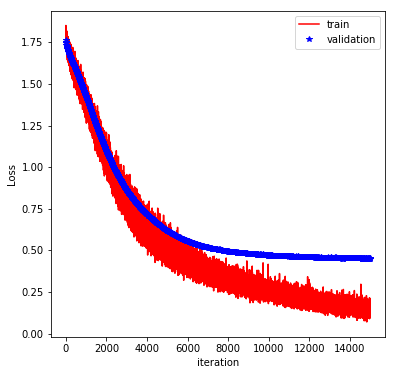

In [12]:
# Plot loss
t = np.arange(iteration - 1)

plt.figure(figsize=(6, 6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

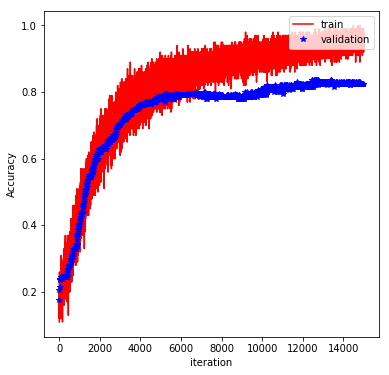

In [13]:
# Plot Accuracies
plt.figure(figsize=(6, 6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [14]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore checkpoint
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    # Dictionary in which to track accuracies based on grip
    accuracy_by_grip = [
        (
            'cylindrical',
            {
                'correct': 0,
                'total': 0
            }
        ),
        (
            'hook', 
            {
                'correct': 0, 
                'total': 0
            }
        ),
        (
            'lateral', 
            {
                'correct': 0, 
                'total': 0
            }
        ),
        (
            'palmar', 
            {
                'correct': 0, 
                'total': 0
            }
        ),
        (
            'spherical', 
            {
                'correct': 0, 
                'total': 0
            }
        ),
        (
            'tip', 
            {
                'correct': 0, 
                'total': 0
            }
        ),
    ]
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {
            inputs_: x_t,
            labels_: y_t,
            keep_prob_: 1
        }
        
        actual = y_t.argmax(axis=1)
        predicted = sess.run(tf.argmax(logits, 1), feed_dict=feed)
        
        for i in range(len(actual)):
            accuracy_by_grip[actual[i]][1]['total'] += 1
            if actual[i] == predicted[i]:
                accuracy_by_grip[actual[i]][1]['correct'] += 1
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
        
    print('Accuracy by grip:')
    
    for grip, grip_data in accuracy_by_grip:
        print('{}: {:.6f}'.format(grip, grip_data['correct'] / grip_data['total']))
        
    print('\nOverall accuracy: {:.6f}'.format(np.mean(test_acc)))
    

INFO:tensorflow:Restoring parameters from checkpoints-cnn/semg.ckpt
Accuracy by grip:
cylindrical: 0.958042
hook: 0.824324
lateral: 0.773333
palmar: 0.658065
spherical: 0.953642
tip: 0.666667

Overall accuracy: 0.803333
